In [149]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Iniciamos lendo os dados do arquivo fornecidp data_tp1 e separando entre os labels e os pixels. Os labels correspondem aos numeros reais, enquanto os pixels os valores correspondentes a imagem de cada numero.

In [150]:
file_path = 'data_tp1'
data = pd.read_csv(file_path, header=None)

label = data.iloc[:, [0]].values
pixels = data.iloc[:, 1:].values

Agora, normalizamos os dados para o treinamento, com o objetivo de manter os valores entre 0 e 1

In [151]:
pixels = pixels / 255.0

Para calcular a real acurácia do modelo, é preciso separar os dados entre o conjunto de treino e validação. Considerando o uso do torch, precisa-se converter os dados para tensores Pytorch para que assim


In [152]:
X_train, X_val, y_train, y_val = train_test_split(pixels, label, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

In [153]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

Agora iniciamos declarando as variaveis a serem usadas nos calculos da rede. Considerando as variaçoes na proposta, algumas sao compostas por listas

In [154]:
# Definir parâmetros iniciais
input_size = 784
hidden_size = [25, 50, 100]  # tamanho camda oculta
output_size = 10
epochs = [10, 50]  # Número de épocas para o mini batch
learning_rate = [0.5, 1, 10]

Para iniciar, primeiro temos que inicializar os pesos iniciais

In [155]:
# Funções de inicialização dos pesos
def initialize_weights(input_size, hidden_size, output_size):
    W1 = torch.randn(input_size, hidden_size, requires_grad=True) * 0.01
    b1 = torch.zeros(hidden_size, requires_grad=True)
    W2 = torch.randn(hidden_size, output_size, requires_grad=True) * 0.01
    b2 = torch.zeros(output_size, requires_grad=True)
    return W1, b1, W2, b2

A função de calculo de acurácia é feita para realizar, ao final, os plots dos gráficos para comparaçao

In [156]:
def calculate_accuracy(output, labels):
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / (labels.size(0))  # Converter para porcentagem
    return accuracy

Por fim, há o treinamento a parter da foward e backword propagation, usando os deferentes calculos de gradientes.


Na foward propagation, os dados sao enviados da camada de entrada para a oculta, onde passam por tratamento e sua saida é enviada para a camada de saida

In [157]:
def forward(x, W1, b1, W2, b2):
    # Entrada para a camada oculta
    z1 = torch.matmul(x, W1) + b1  # Multiplicação de pesos e soma com bias
    a1 = torch.sigmoid(z1)         # Aplicação da função de ativação (Sigmoid)

    # Camada oculta para a camada de saída
    z2 = torch.matmul(a1, W2) + b2  # Multiplicação de pesos e soma com bias

    return z1, a1, z2

No treinamento, portanto, há tres caminhos possiveis, devido as tres formas de se calcular o gradiente

In [158]:
def train(model_type, val_loader, train_loader, input_size, hidden_size, output_size, learning_rate, epochs, batch_size=None):
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)
     # Garantir que os tensores de pesos e vieses (biases) são tensores "folha" (leaf tensors) antes de passá-los para o otimizador.
    W1 = W1.clone().detach().requires_grad_(True)
    b1 = b1.clone().detach().requires_grad_(True)
    W2 = W2.clone().detach().requires_grad_(True)
    b2 = b2.clone().detach().requires_grad_(True)
    # calculo do otimizador
    optimizer = optim.SGD([W1, b1, W2, b2], lr=learning_rate)
    # calculo da funcao deperda cross entropy
    criterion = torch.nn.CrossEntropyLoss()

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []


    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0

        if model_type == 'sgd':
            for images, labels in train_loader:
                if labels.dtype != torch.long:
                  labels = labels.long()
                images = images.view(-1, input_size)

                # Zerar os gradientes
                optimizer.zero_grad()

                # Forward pass
                _, _, z2 = forward(images, W1, b1, W2, b2)

                # Calcular a perda
                loss = criterion(z2, labels.view(-1))
                total_train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Atualizar os pesos
                optimizer.step()

                # Calcular acurácia
                total_train_correct += calculate_accuracy(z2, labels)

        elif model_type == 'mini_batch':
            for i in range(0, len(train_loader.dataset), batch_size):
                batch_images, batch_labels = zip(*[train_loader.dataset[j] for j in range(i, min(i+batch_size, len(train_loader.dataset)))])
                batch_images = torch.stack(batch_images)
                batch_labels = torch.tensor(batch_labels)
                batch_images = batch_images.view(-1, input_size)

                # Zerar os gradientes
                optimizer.zero_grad()

                # Forward pass
                _, _, z2 = forward(batch_images, W1, b1, W2, b2)

                # Calcular a perda
                loss = criterion(z2, batch_labels.view(-1))
                total_train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Atualizar os pesos
                optimizer.step()

                # Calcular acurácia
                total_train_correct += calculate_accuracy(z2, batch_labels)

        elif model_type == 'gradient_descent':
            all_images = []
            all_labels = []
            for images, labels in train_loader:
                all_images.append(images)
                all_labels.append(labels)

            all_images = torch.cat(all_images).view(-1, input_size)
            all_labels = torch.cat(all_labels)

            # Zerar os gradientes
            optimizer.zero_grad()

            # Forward pass
            _, _, z2 = forward(all_images, W1, b1, W2, b2)

            # Calcular a perda
            loss = criterion(z2, all_labels.view(-1))
            total_train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Atualizar os pesos
            optimizer.step()

            # Calcular acurácia
            total_train_correct += calculate_accuracy(z2, all_labels)

        train_accuracy = total_train_correct / len(train_loader.dataset)
        train_loss_history.append(total_train_loss / len(train_loader))
        train_accuracy_history.append(train_accuracy)

        # Validação
        total_val_loss = 0
        total_val_correct = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.view(-1, input_size)
                val_labels = val_labels.view(-1)

                # Forward pass
                _, _, z2_val = forward(val_images, W1, b1, W2, b2)

                # Calcular a perda
                val_loss = criterion(z2_val, val_labels.view(-1))
                total_val_loss += val_loss.item()

                # Calcular acurácia
                total_val_correct += calculate_accuracy(z2_val, val_labels)

        val_accuracy = total_val_correct / len(val_loader.dataset)
        val_loss_history.append(total_val_loss / len(val_loader))
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {total_train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {total_val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}')

    return W1, b1, W2, b2, train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history  # Retornar os pesos finais




Graficos

In [159]:
def plot_results(train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history, title):
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(14, 10))

    # Gráfico de perda de treino e validação
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
    plt.plot(epochs, val_loss_history, 'r', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de acurácia de treino e validação
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracy_history, 'b', label='Train Accuracy')
    plt.plot(epochs, val_accuracy_history, 'r', label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Agora, iniciamos com o sgd

In [160]:
# Criar DataLoader para SGD e Gradient Descent
train_loader_sgd = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader_sgd = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)



Training using size of the hidden layer:
25



Training using learning rate:
0.5



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 1.2738, Train Accuracy: 0.5703, Val Loss: 1.0476, Val Accuracy: 0.6920
Epoch [2/5], Train Loss: 1.0126, Train Accuracy: 0.7057, Val Loss: 1.2248, Val Accuracy: 0.6040
Epoch [3/5], Train Loss: 0.9438, Train Accuracy: 0.7325, Val Loss: 0.9410, Val Accuracy: 0.7530
Epoch [4/5], Train Loss: 0.7219, Train Accuracy: 0.7910, Val Loss: 0.7562, Val Accuracy: 0.7790
Epoch [5/5], Train Loss: 0.6888, Train Accuracy: 0.8035, Val Loss: 0.7465, Val Accuracy: 0.8080


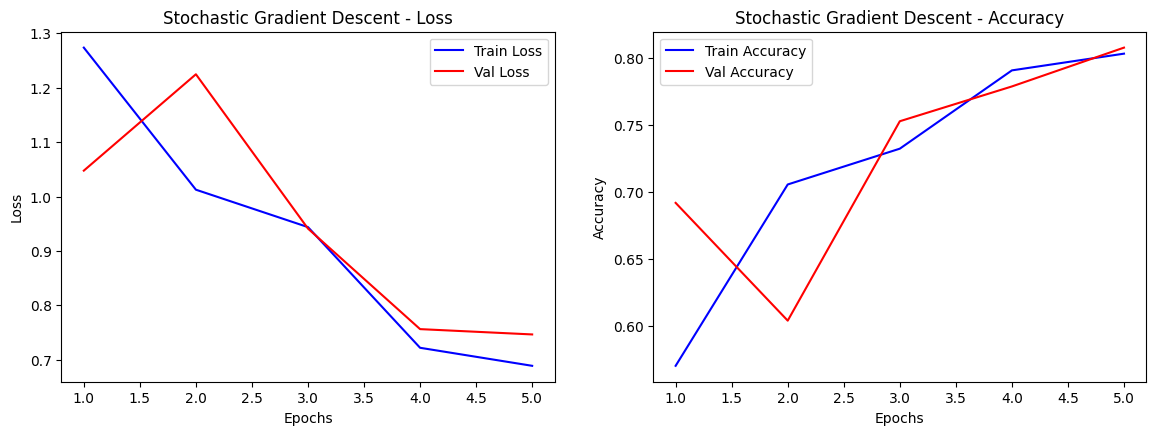


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.0858, Val Loss: 2.3024, Val Accuracy: 0.1130
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3034, Val Accuracy: 0.1130
Epoch [3/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3043, Val Accuracy: 0.1130
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3048, Val Accuracy: 0.1130
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3051, Val Accuracy: 0.1130


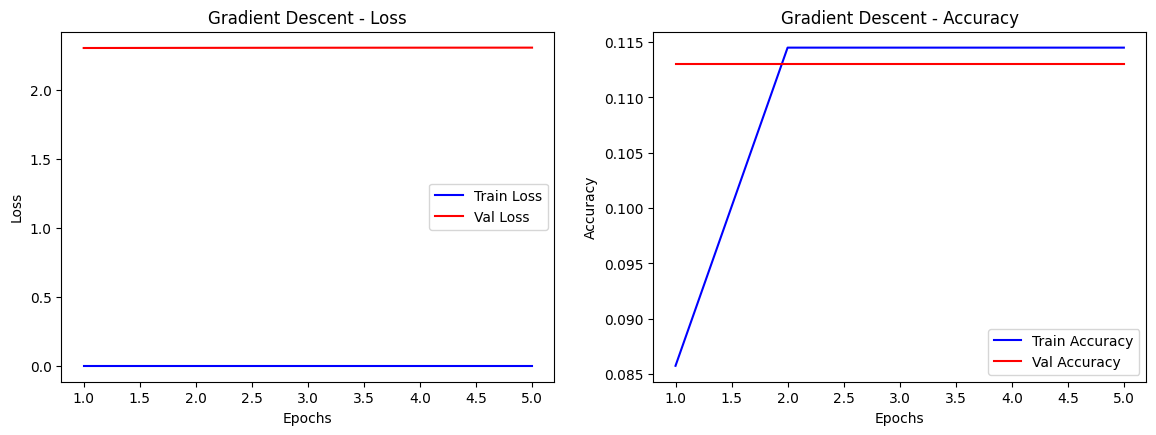


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 1.2235, Train Accuracy: 0.0595, Val Loss: 0.5483, Val Accuracy: 0.0831
Epoch [2/5], Train Loss: 0.4241, Train Accuracy: 0.0875, Val Loss: 0.3959, Val Accuracy: 0.0878
Epoch [3/5], Train Loss: 0.3030, Train Accuracy: 0.0911, Val Loss: 0.3417, Val Accuracy: 0.0903
Epoch [4/5], Train Loss: 0.2354, Train Accuracy: 0.0932, Val Loss: 0.3192, Val Accuracy: 0.0903
Epoch [5/5], Train Loss: 0.1877, Train Accuracy: 0.0948, Val Loss: 0.3114, Val Accuracy: 0.0908


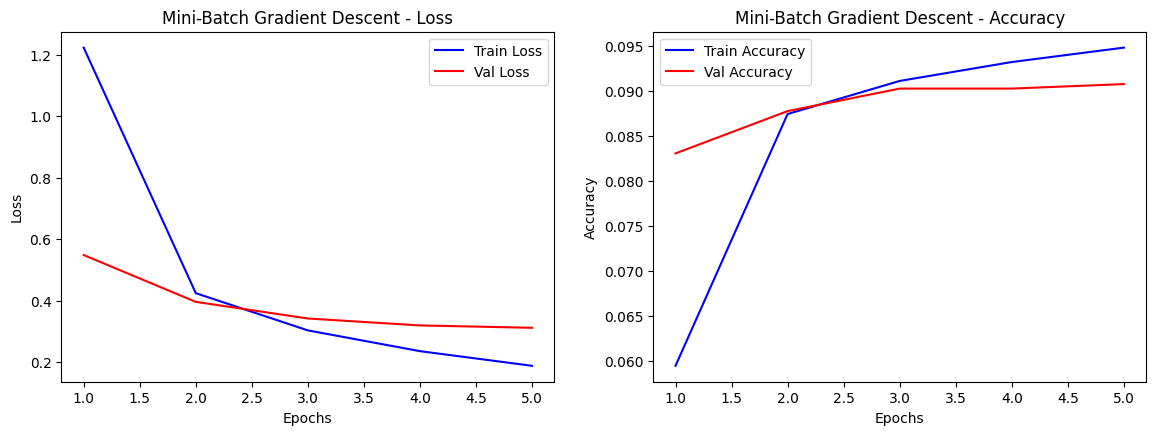

Epoch [1/5], Train Loss: 2.1589, Train Accuracy: 0.0044, Val Loss: 1.6854, Val Accuracy: 0.0092
Epoch [2/5], Train Loss: 1.1869, Train Accuracy: 0.0130, Val Loss: 0.8713, Val Accuracy: 0.0157
Epoch [3/5], Train Loss: 0.7058, Train Accuracy: 0.0162, Val Loss: 0.6129, Val Accuracy: 0.0168
Epoch [4/5], Train Loss: 0.5270, Train Accuracy: 0.0171, Val Loss: 0.5053, Val Accuracy: 0.0173
Epoch [5/5], Train Loss: 0.4342, Train Accuracy: 0.0176, Val Loss: 0.4459, Val Accuracy: 0.0176


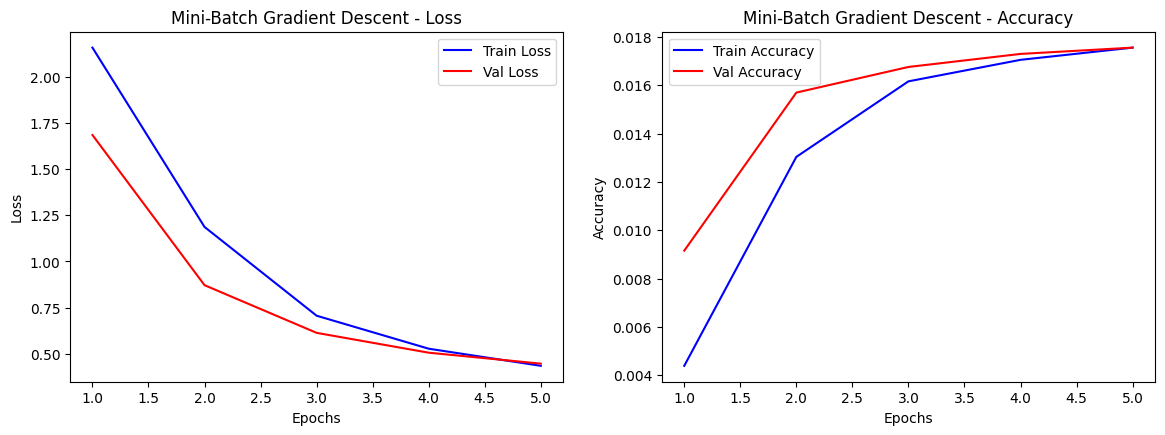


Training using learning rate:
1



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 1.8546, Train Accuracy: 0.3867, Val Loss: 1.9723, Val Accuracy: 0.0088
Epoch [2/5], Train Loss: 1.6304, Train Accuracy: 0.5182, Val Loss: 1.3451, Val Accuracy: 0.0127
Epoch [3/5], Train Loss: 1.6699, Train Accuracy: 0.5645, Val Loss: 2.5478, Val Accuracy: 0.0108
Epoch [4/5], Train Loss: 1.6276, Train Accuracy: 0.5803, Val Loss: 1.2273, Val Accuracy: 0.0134
Epoch [5/5], Train Loss: 1.1878, Train Accuracy: 0.6635, Val Loss: 1.3262, Val Accuracy: 0.0113


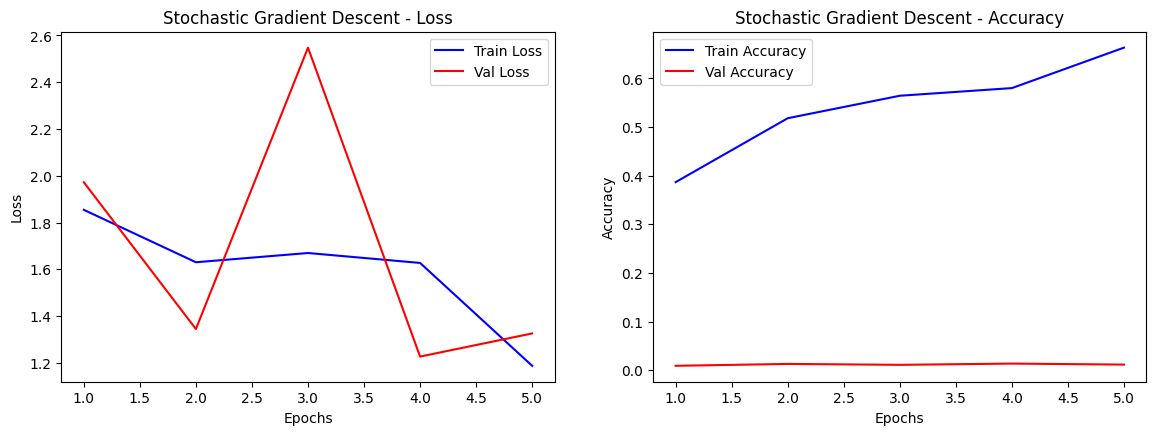


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.0985, Val Loss: 2.3051, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3059, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3058, Val Accuracy: 0.0023
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3055, Val Accuracy: 0.0023
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3050, Val Accuracy: 0.0023


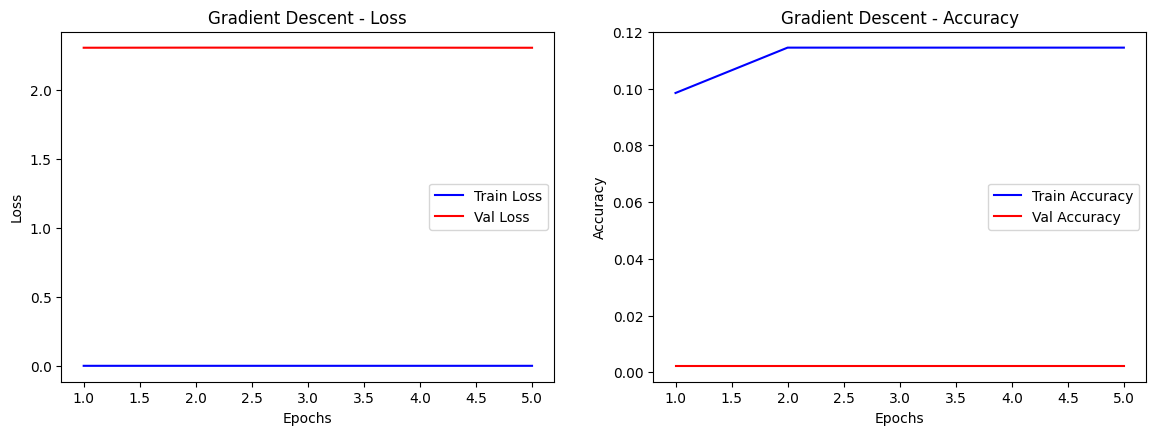


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 1.0252, Train Accuracy: 0.0649, Val Loss: 0.5479, Val Accuracy: 0.0824
Epoch [2/5], Train Loss: 0.3882, Train Accuracy: 0.0876, Val Loss: 0.4034, Val Accuracy: 0.0865
Epoch [3/5], Train Loss: 0.2673, Train Accuracy: 0.0918, Val Loss: 0.3705, Val Accuracy: 0.0890
Epoch [4/5], Train Loss: 0.1996, Train Accuracy: 0.0936, Val Loss: 0.3294, Val Accuracy: 0.0905
Epoch [5/5], Train Loss: 0.1482, Train Accuracy: 0.0956, Val Loss: 0.2947, Val Accuracy: 0.0911


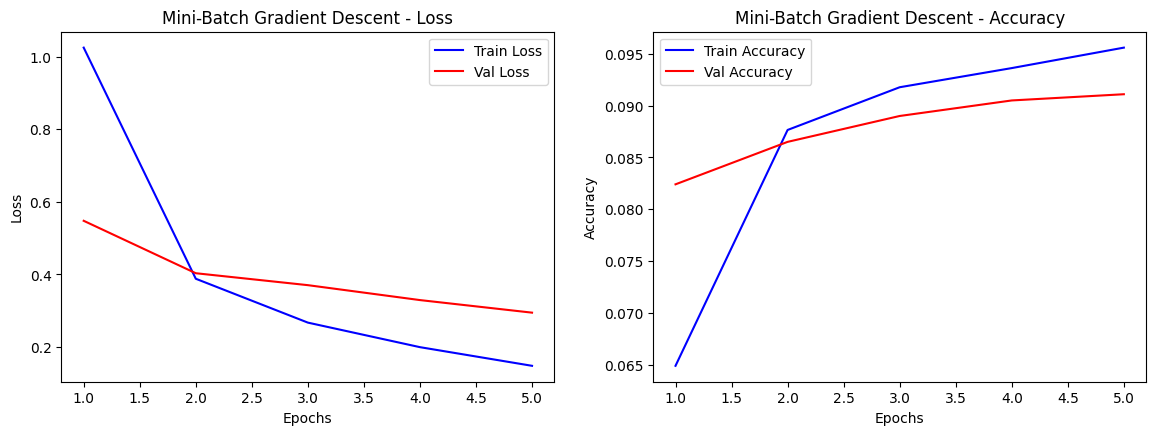

Epoch [1/5], Train Loss: 1.7610, Train Accuracy: 0.0077, Val Loss: 0.9605, Val Accuracy: 0.0153
Epoch [2/5], Train Loss: 0.6805, Train Accuracy: 0.0161, Val Loss: 0.5374, Val Accuracy: 0.0169
Epoch [3/5], Train Loss: 0.4389, Train Accuracy: 0.0175, Val Loss: 0.4256, Val Accuracy: 0.0174
Epoch [4/5], Train Loss: 0.3477, Train Accuracy: 0.0180, Val Loss: 0.3716, Val Accuracy: 0.0178
Epoch [5/5], Train Loss: 0.2934, Train Accuracy: 0.0183, Val Loss: 0.3415, Val Accuracy: 0.0180


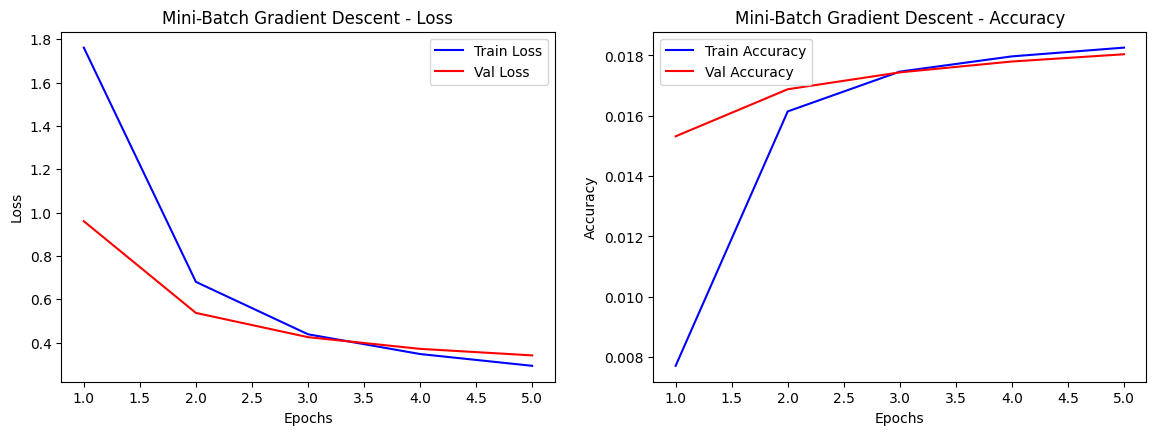


Training using learning rate:
10



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 8.9995, Train Accuracy: 0.1015, Val Loss: 8.7717, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 8.9679, Train Accuracy: 0.1032, Val Loss: 8.9236, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 8.9754, Train Accuracy: 0.1025, Val Loss: 9.1748, Val Accuracy: 0.0018
Epoch [4/5], Train Loss: 9.0729, Train Accuracy: 0.0927, Val Loss: 9.1501, Val Accuracy: 0.0017
Epoch [5/5], Train Loss: 8.9279, Train Accuracy: 0.1072, Val Loss: 8.9343, Val Accuracy: 0.0021


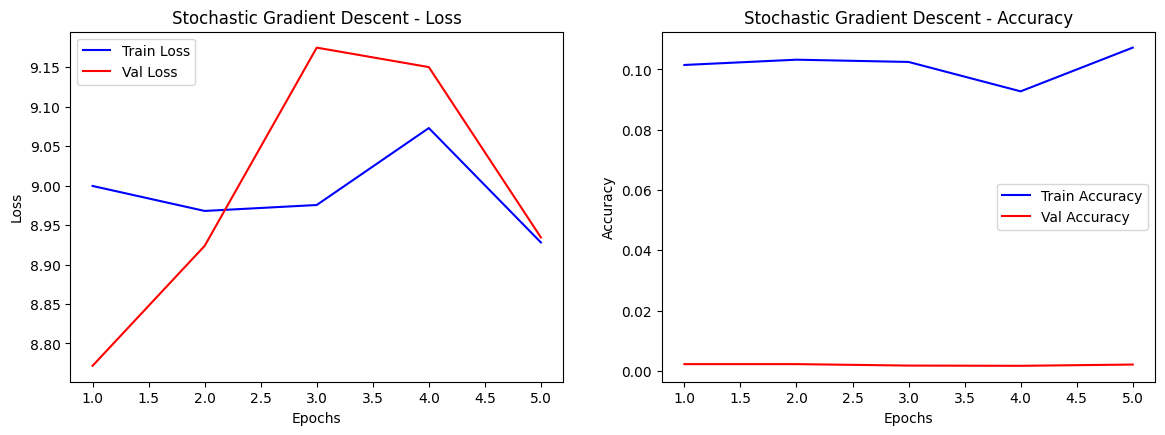


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.0984, Val Loss: 2.5036, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 3.0144, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 0.0008, Train Accuracy: 0.0858, Val Loss: 2.3639, Val Accuracy: 0.0020
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1055, Val Loss: 2.3135, Val Accuracy: 0.0023
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1144, Val Loss: 2.3075, Val Accuracy: 0.0022


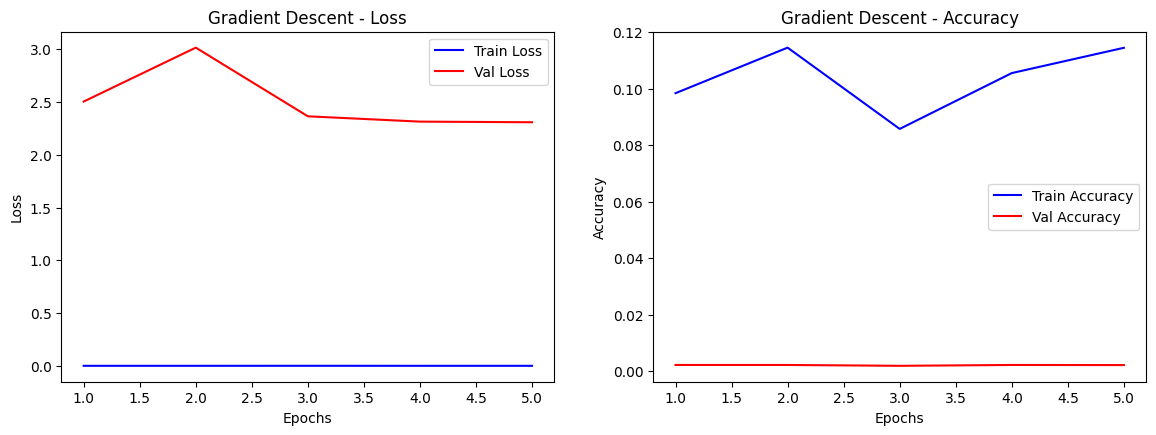


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 2.9775, Train Accuracy: 0.0107, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [2/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [3/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [4/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [5/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096


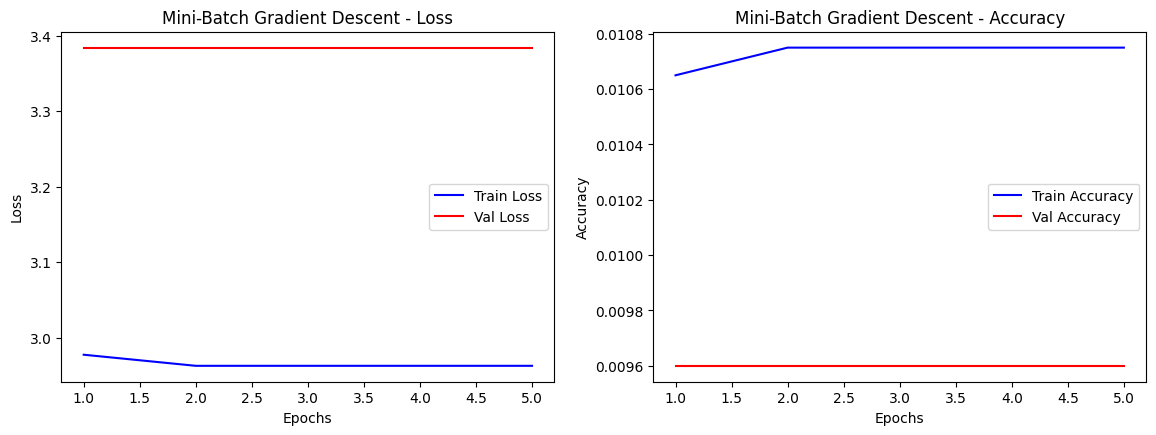

Epoch [1/5], Train Loss: 2.4415, Train Accuracy: 0.0022, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [2/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [3/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [4/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [5/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018


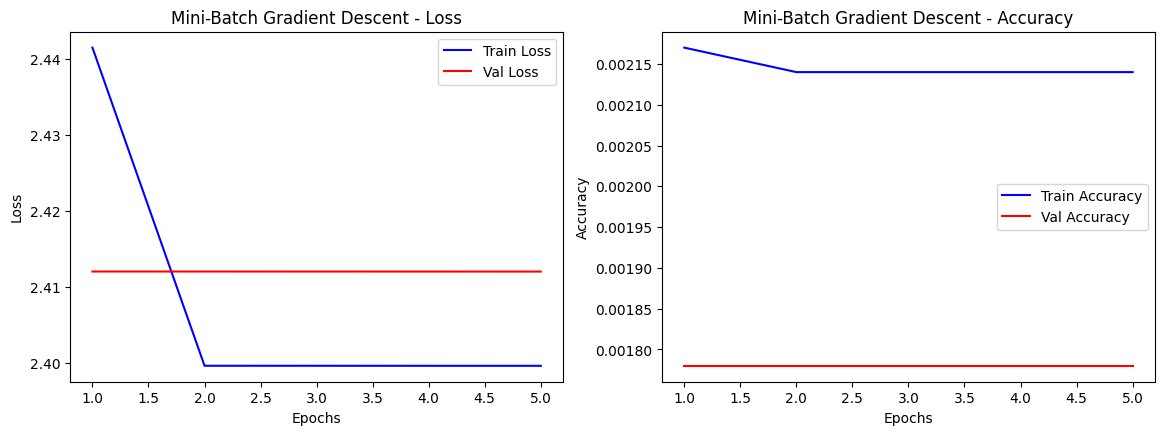


Training using size of the hidden layer:
50



Training using learning rate:
0.5



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 1.1525, Train Accuracy: 0.6235, Val Loss: 0.7113, Val Accuracy: 0.0157
Epoch [2/5], Train Loss: 0.7978, Train Accuracy: 0.7652, Val Loss: 1.0557, Val Accuracy: 0.0140
Epoch [3/5], Train Loss: 0.7088, Train Accuracy: 0.7875, Val Loss: 0.6811, Val Accuracy: 0.0164
Epoch [4/5], Train Loss: 0.6052, Train Accuracy: 0.8245, Val Loss: 0.6608, Val Accuracy: 0.0160
Epoch [5/5], Train Loss: 0.5609, Train Accuracy: 0.8283, Val Loss: 0.6344, Val Accuracy: 0.0169


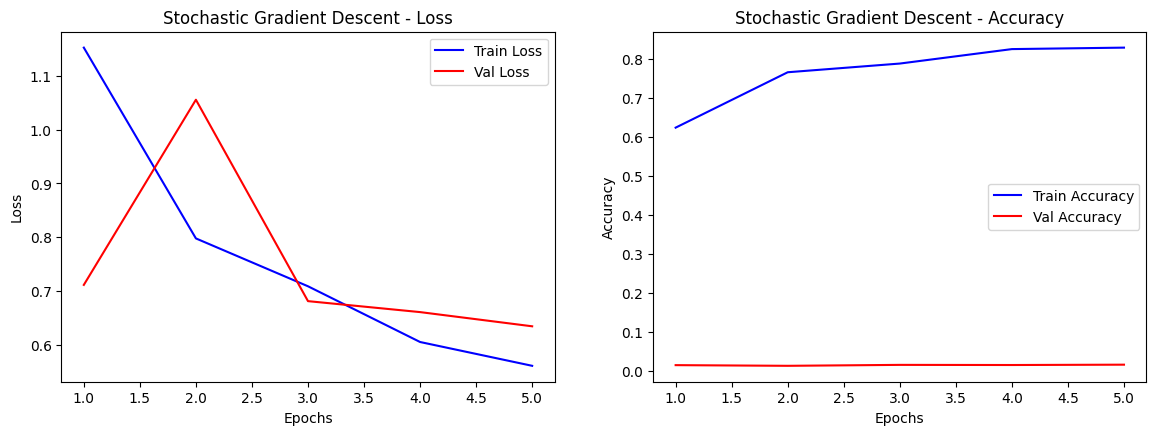


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.1037, Val Loss: 2.3051, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3057, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3058, Val Accuracy: 0.0023
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3056, Val Accuracy: 0.0023
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3054, Val Accuracy: 0.0023


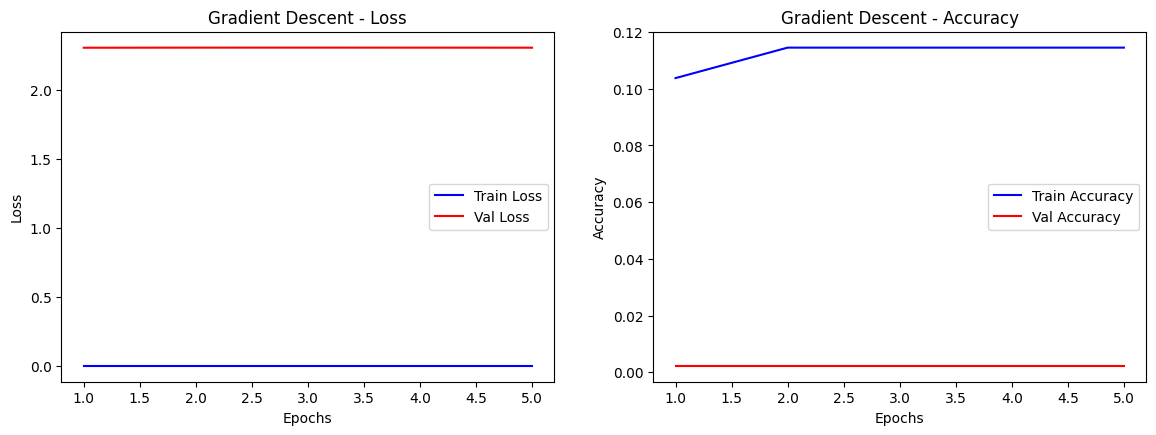


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 1.1447, Train Accuracy: 0.0613, Val Loss: 0.5143, Val Accuracy: 0.0832
Epoch [2/5], Train Loss: 0.3936, Train Accuracy: 0.0876, Val Loss: 0.3725, Val Accuracy: 0.0886
Epoch [3/5], Train Loss: 0.2792, Train Accuracy: 0.0910, Val Loss: 0.3270, Val Accuracy: 0.0904
Epoch [4/5], Train Loss: 0.2082, Train Accuracy: 0.0934, Val Loss: 0.3061, Val Accuracy: 0.0909
Epoch [5/5], Train Loss: 0.1568, Train Accuracy: 0.0955, Val Loss: 0.2936, Val Accuracy: 0.0915


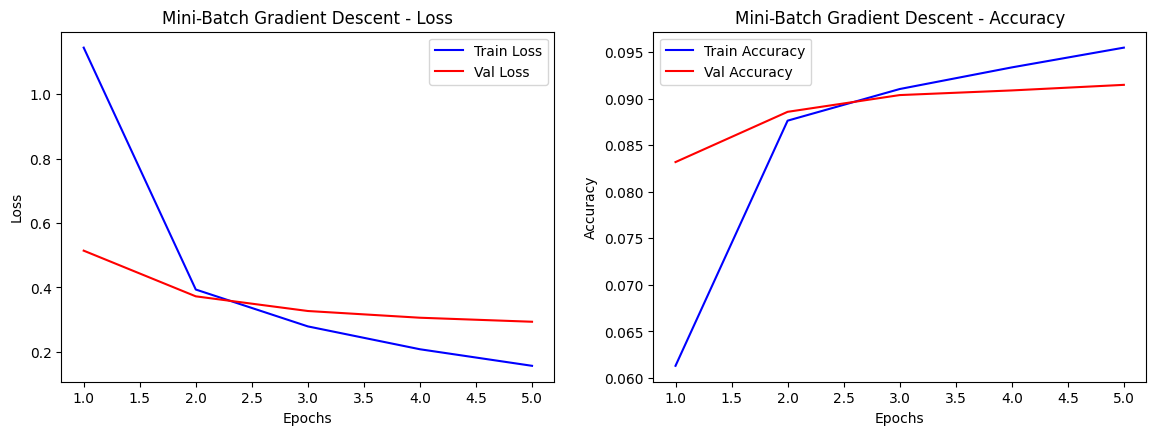

Epoch [1/5], Train Loss: 2.0786, Train Accuracy: 0.0051, Val Loss: 1.4740, Val Accuracy: 0.0107
Epoch [2/5], Train Loss: 1.0103, Train Accuracy: 0.0140, Val Loss: 0.7405, Val Accuracy: 0.0161
Epoch [3/5], Train Loss: 0.6204, Train Accuracy: 0.0162, Val Loss: 0.5540, Val Accuracy: 0.0168
Epoch [4/5], Train Loss: 0.4789, Train Accuracy: 0.0172, Val Loss: 0.4665, Val Accuracy: 0.0172
Epoch [5/5], Train Loss: 0.3999, Train Accuracy: 0.0176, Val Loss: 0.4158, Val Accuracy: 0.0175


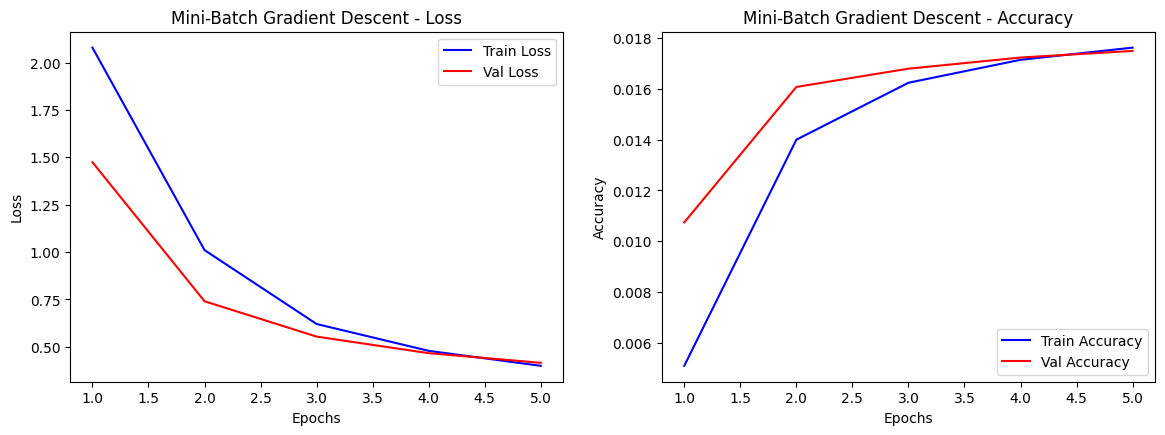


Training using learning rate:
1



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 2.2937, Train Accuracy: 0.3967, Val Loss: 2.2816, Val Accuracy: 0.0097
Epoch [2/5], Train Loss: 3.6645, Train Accuracy: 0.4595, Val Loss: 1.8595, Val Accuracy: 0.0127
Epoch [3/5], Train Loss: 3.8180, Train Accuracy: 0.5495, Val Loss: 7.7123, Val Accuracy: 0.0086
Epoch [4/5], Train Loss: 4.2801, Train Accuracy: 0.5195, Val Loss: 3.0832, Val Accuracy: 0.0123
Epoch [5/5], Train Loss: 3.3274, Train Accuracy: 0.5800, Val Loss: 3.3554, Val Accuracy: 0.0120


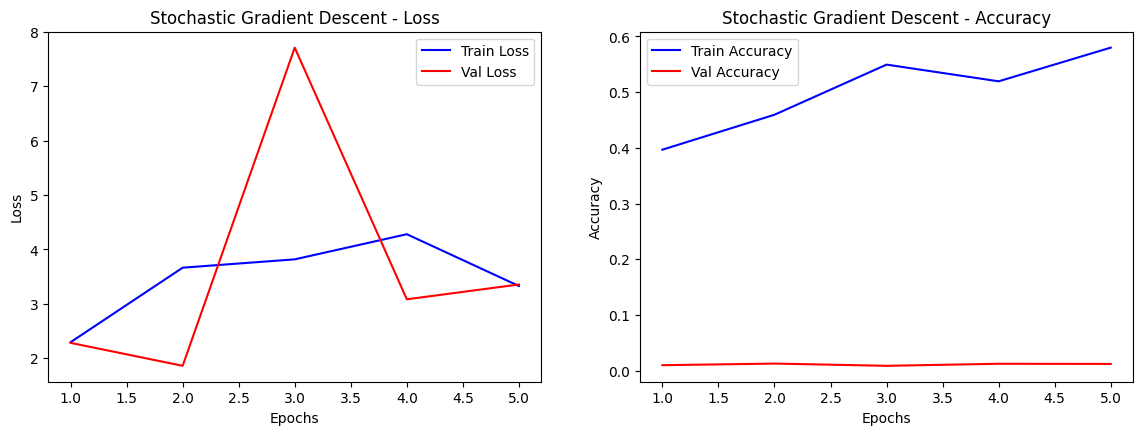


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.0953, Val Loss: 2.3103, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3047, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3052, Val Accuracy: 0.0023
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3039, Val Accuracy: 0.0023
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3031, Val Accuracy: 0.0023


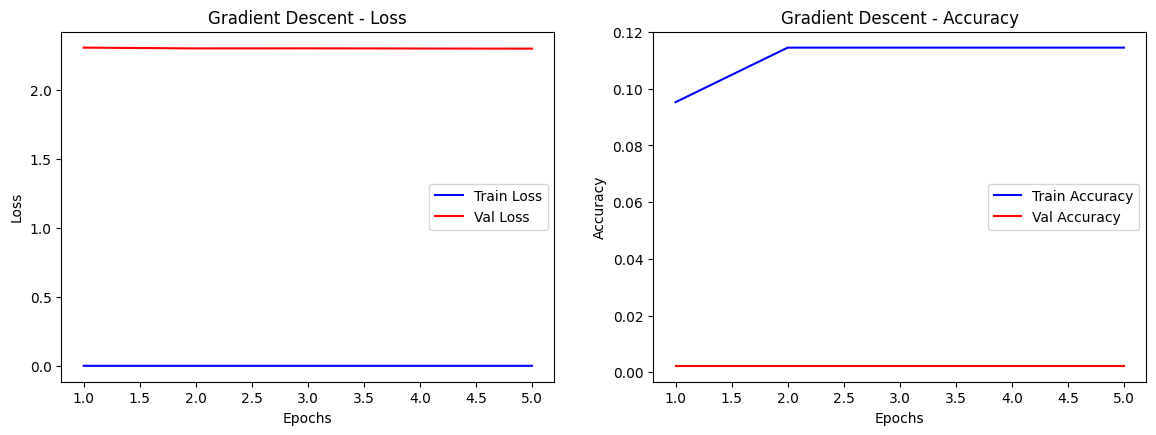


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 1.0136, Train Accuracy: 0.0655, Val Loss: 0.5241, Val Accuracy: 0.0821
Epoch [2/5], Train Loss: 0.3797, Train Accuracy: 0.0877, Val Loss: 0.3851, Val Accuracy: 0.0872
Epoch [3/5], Train Loss: 0.2472, Train Accuracy: 0.0918, Val Loss: 0.3514, Val Accuracy: 0.0890
Epoch [4/5], Train Loss: 0.1666, Train Accuracy: 0.0949, Val Loss: 0.3289, Val Accuracy: 0.0904
Epoch [5/5], Train Loss: 0.1107, Train Accuracy: 0.0969, Val Loss: 0.2974, Val Accuracy: 0.0917


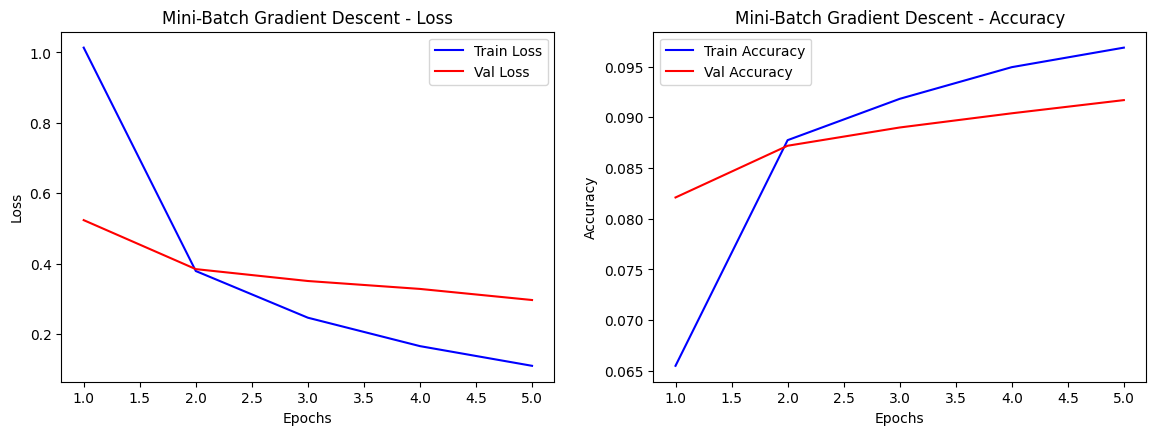

Epoch [1/5], Train Loss: 1.7265, Train Accuracy: 0.0077, Val Loss: 0.8462, Val Accuracy: 0.0157
Epoch [2/5], Train Loss: 0.6187, Train Accuracy: 0.0163, Val Loss: 0.5106, Val Accuracy: 0.0169
Epoch [3/5], Train Loss: 0.4120, Train Accuracy: 0.0175, Val Loss: 0.4113, Val Accuracy: 0.0175
Epoch [4/5], Train Loss: 0.3274, Train Accuracy: 0.0180, Val Loss: 0.3597, Val Accuracy: 0.0180
Epoch [5/5], Train Loss: 0.2741, Train Accuracy: 0.0183, Val Loss: 0.3287, Val Accuracy: 0.0182


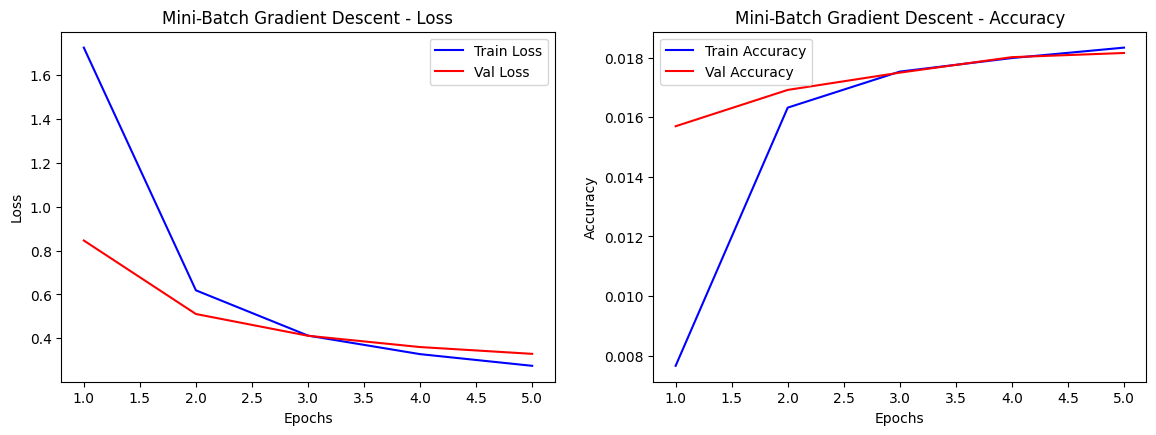


Training using learning rate:
10



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 9.0945, Train Accuracy: 0.0943, Val Loss: 8.9458, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 9.0104, Train Accuracy: 0.0990, Val Loss: 9.1942, Val Accuracy: 0.0017
Epoch [3/5], Train Loss: 9.0354, Train Accuracy: 0.0965, Val Loss: 9.0280, Val Accuracy: 0.0020
Epoch [4/5], Train Loss: 8.9779, Train Accuracy: 0.1022, Val Loss: 8.9027, Val Accuracy: 0.0022
Epoch [5/5], Train Loss: 8.9879, Train Accuracy: 0.1013, Val Loss: 8.9643, Val Accuracy: 0.0023


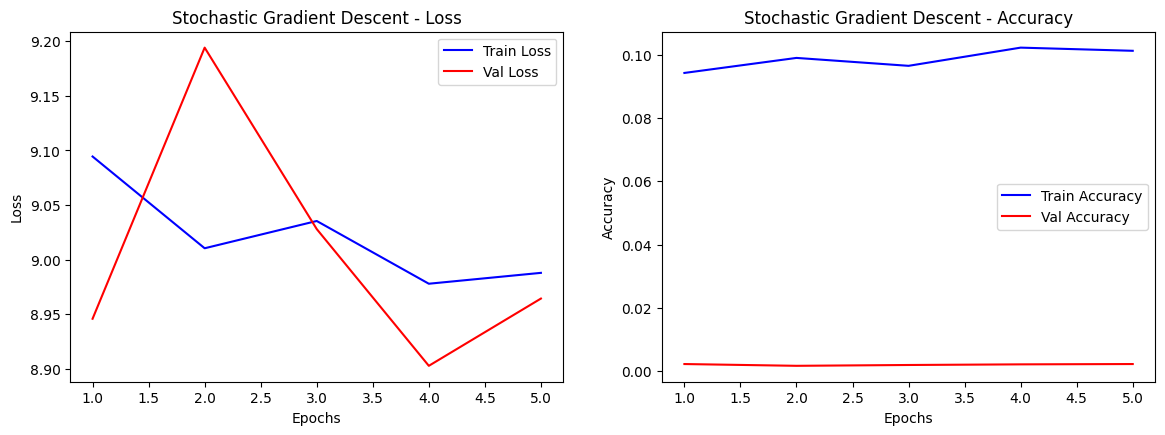


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.1103, Val Loss: 2.9142, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0007, Train Accuracy: 0.1145, Val Loss: 4.1725, Val Accuracy: 0.0019
Epoch [3/5], Train Loss: 0.0011, Train Accuracy: 0.0915, Val Loss: 2.5502, Val Accuracy: 0.0018
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1094, Val Loss: 2.3922, Val Accuracy: 0.0022
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1095, Val Loss: 2.3225, Val Accuracy: 0.0018


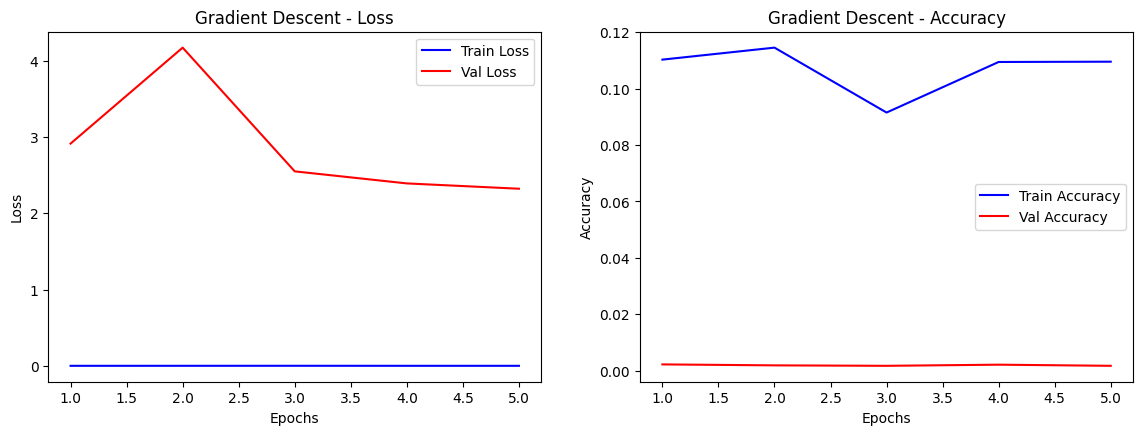


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 2.9963, Train Accuracy: 0.0107, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [2/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [3/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [4/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [5/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096


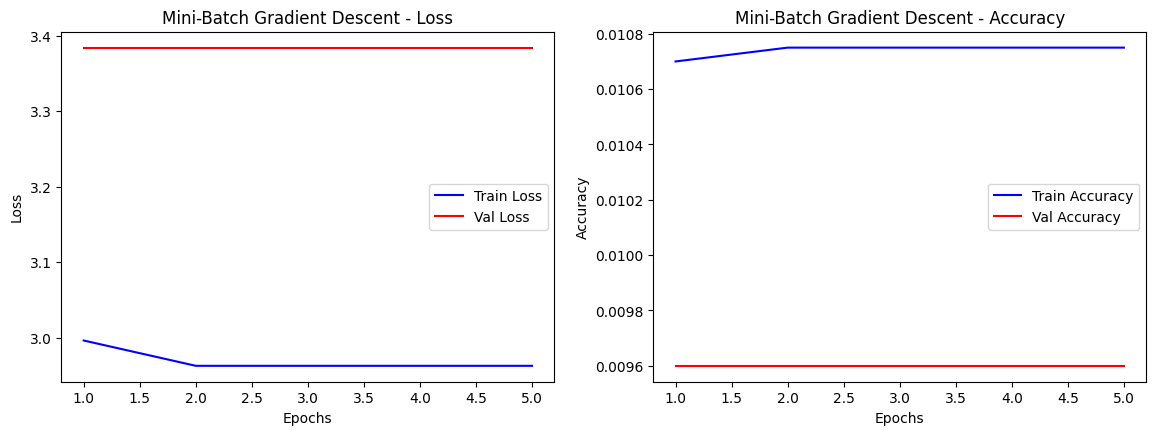

Epoch [1/5], Train Loss: 2.5037, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [2/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [3/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [4/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [5/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018


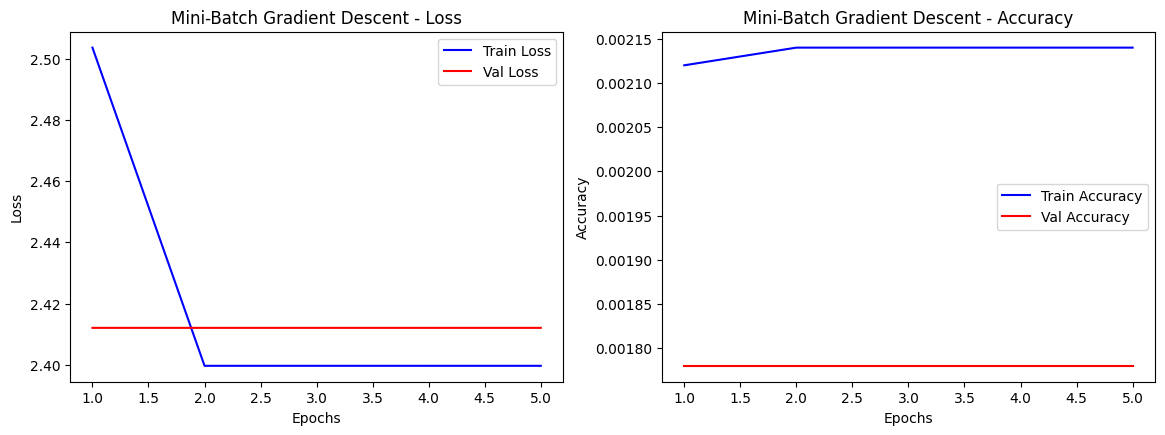


Training using size of the hidden layer:
100



Training using learning rate:
0.5



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 1.2659, Train Accuracy: 0.5955, Val Loss: 1.4663, Val Accuracy: 0.0127
Epoch [2/5], Train Loss: 1.2598, Train Accuracy: 0.7037, Val Loss: 0.9438, Val Accuracy: 0.0150
Epoch [3/5], Train Loss: 1.2748, Train Accuracy: 0.7480, Val Loss: 2.0078, Val Accuracy: 0.0134
Epoch [4/5], Train Loss: 1.4800, Train Accuracy: 0.7502, Val Loss: 1.8052, Val Accuracy: 0.0145
Epoch [5/5], Train Loss: 1.7101, Train Accuracy: 0.7470, Val Loss: 1.5419, Val Accuracy: 0.0151


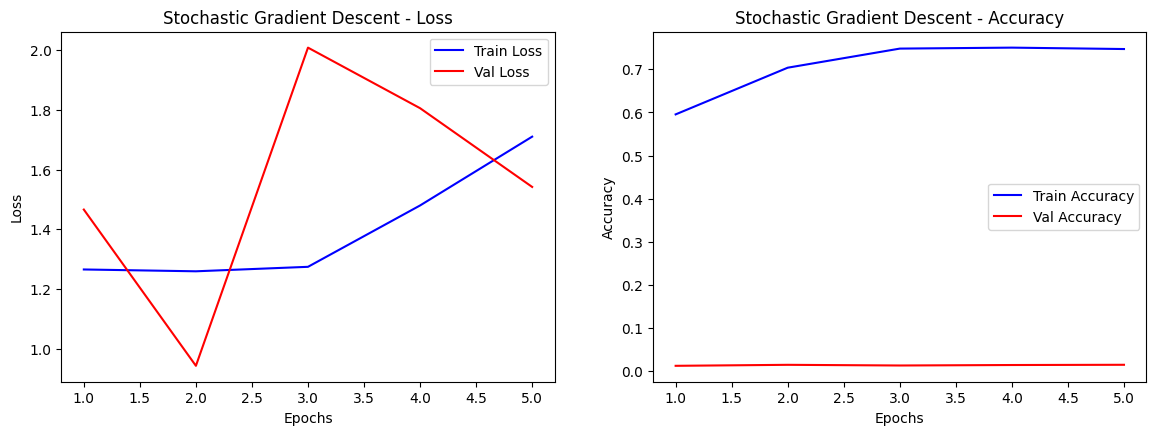


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.0943, Val Loss: 2.3083, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3049, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3049, Val Accuracy: 0.0023
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3040, Val Accuracy: 0.0023
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3034, Val Accuracy: 0.0023


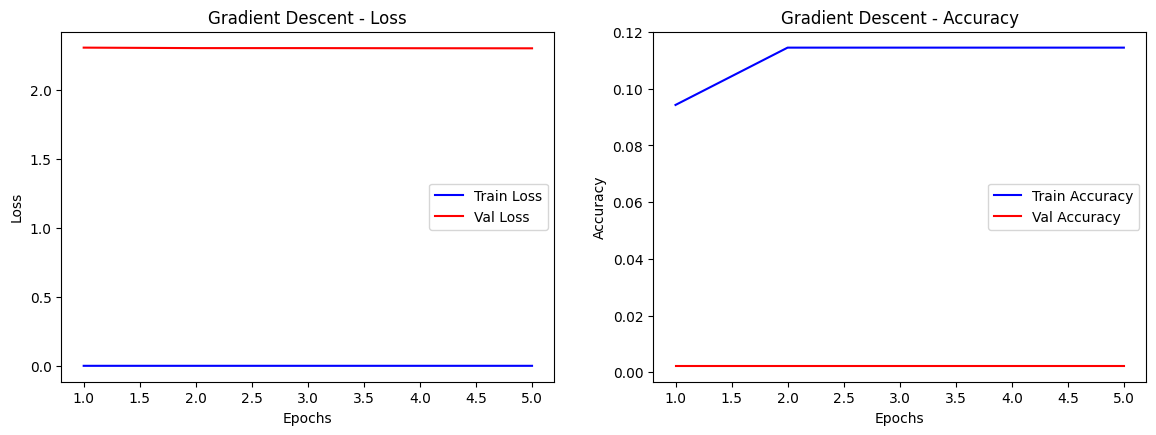


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 1.1116, Train Accuracy: 0.0620, Val Loss: 0.5122, Val Accuracy: 0.0833
Epoch [2/5], Train Loss: 0.3797, Train Accuracy: 0.0879, Val Loss: 0.3589, Val Accuracy: 0.0890
Epoch [3/5], Train Loss: 0.2640, Train Accuracy: 0.0917, Val Loss: 0.3080, Val Accuracy: 0.0913
Epoch [4/5], Train Loss: 0.1933, Train Accuracy: 0.0941, Val Loss: 0.2836, Val Accuracy: 0.0913
Epoch [5/5], Train Loss: 0.1433, Train Accuracy: 0.0958, Val Loss: 0.2696, Val Accuracy: 0.0925


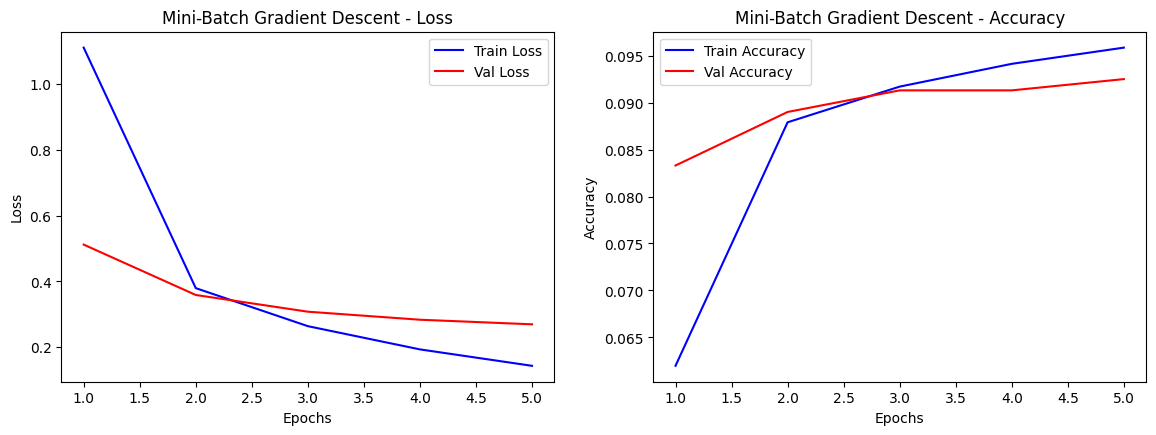

Epoch [1/5], Train Loss: 2.0644, Train Accuracy: 0.0051, Val Loss: 1.3606, Val Accuracy: 0.0114
Epoch [2/5], Train Loss: 0.9353, Train Accuracy: 0.0144, Val Loss: 0.6854, Val Accuracy: 0.0163
Epoch [3/5], Train Loss: 0.5719, Train Accuracy: 0.0165, Val Loss: 0.5218, Val Accuracy: 0.0169
Epoch [4/5], Train Loss: 0.4470, Train Accuracy: 0.0173, Val Loss: 0.4490, Val Accuracy: 0.0172
Epoch [5/5], Train Loss: 0.3808, Train Accuracy: 0.0177, Val Loss: 0.4079, Val Accuracy: 0.0175


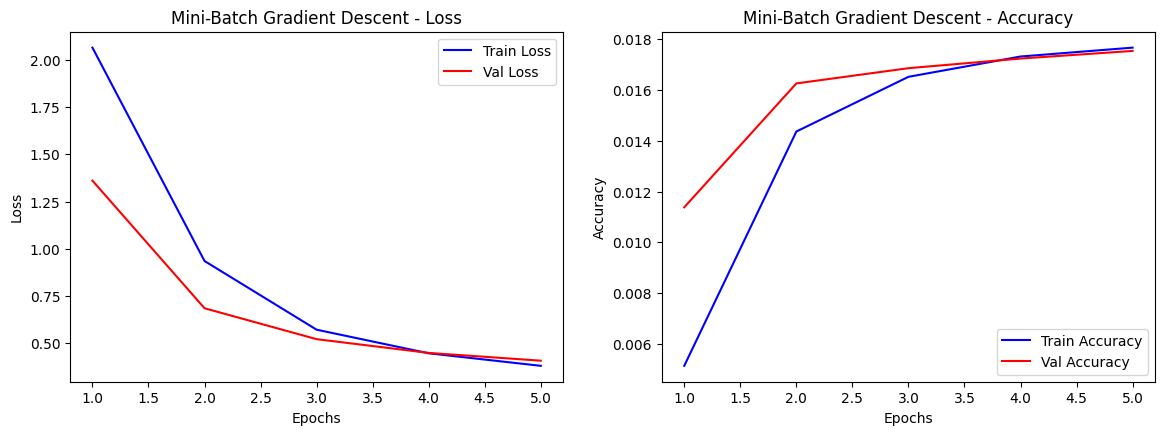


Training using learning rate:
1



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 3.0626, Train Accuracy: 0.3862, Val Loss: 5.1472, Val Accuracy: 0.0082
Epoch [2/5], Train Loss: 9.1385, Train Accuracy: 0.4295, Val Loss: 9.3758, Val Accuracy: 0.0093
Epoch [3/5], Train Loss: 11.4680, Train Accuracy: 0.4407, Val Loss: 15.7168, Val Accuracy: 0.0083
Epoch [4/5], Train Loss: 11.5522, Train Accuracy: 0.4745, Val Loss: 25.2880, Val Accuracy: 0.0074
Epoch [5/5], Train Loss: 13.8488, Train Accuracy: 0.4625, Val Loss: 13.1735, Val Accuracy: 0.0100


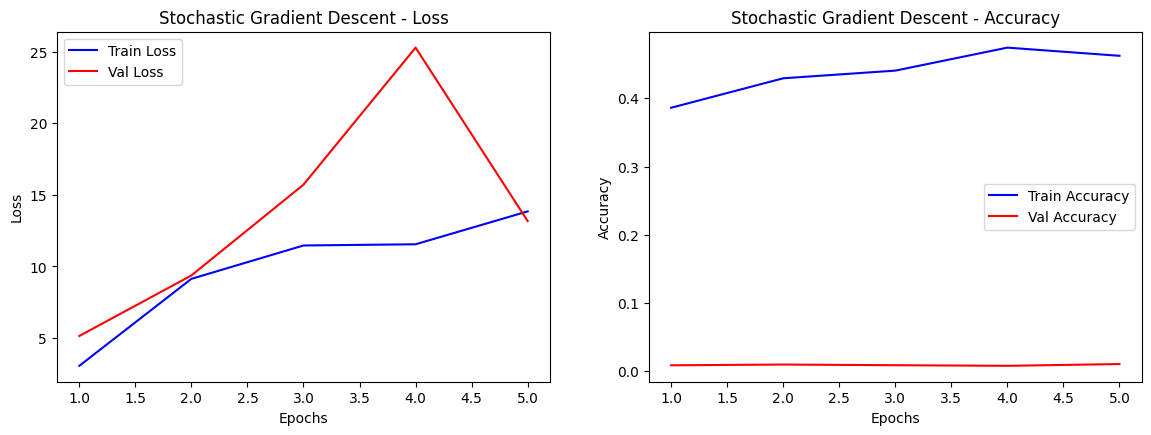


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.1095, Val Loss: 2.3212, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.3328, Val Accuracy: 0.0017
Epoch [3/5], Train Loss: 0.0006, Train Accuracy: 0.0943, Val Loss: 2.3748, Val Accuracy: 0.0023
Epoch [4/5], Train Loss: 0.0006, Train Accuracy: 0.1145, Val Loss: 2.4955, Val Accuracy: 0.0017
Epoch [5/5], Train Loss: 0.0006, Train Accuracy: 0.0943, Val Loss: 2.3787, Val Accuracy: 0.0023


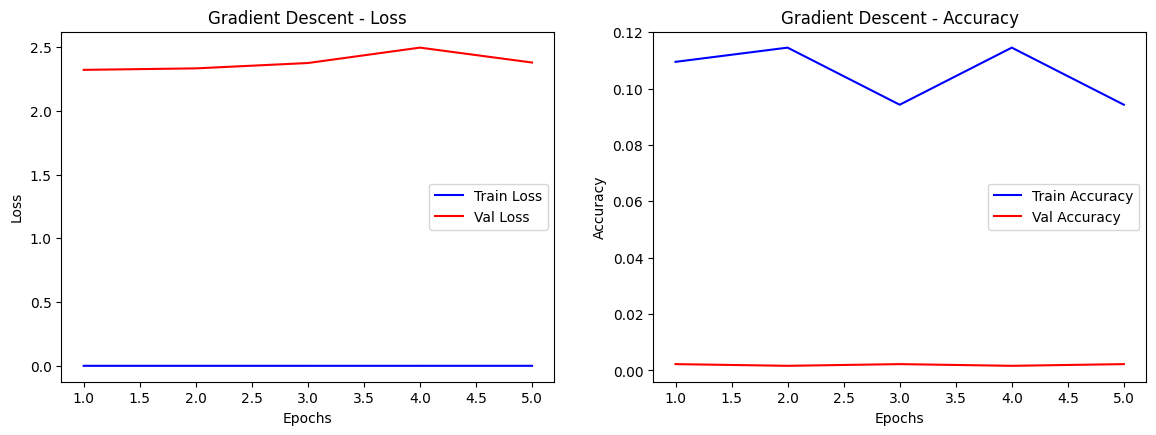


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 1.0420, Train Accuracy: 0.0649, Val Loss: 0.4867, Val Accuracy: 0.0849
Epoch [2/5], Train Loss: 0.3560, Train Accuracy: 0.0886, Val Loss: 0.3335, Val Accuracy: 0.0902
Epoch [3/5], Train Loss: 0.2326, Train Accuracy: 0.0928, Val Loss: 0.3093, Val Accuracy: 0.0916
Epoch [4/5], Train Loss: 0.1559, Train Accuracy: 0.0950, Val Loss: 0.3175, Val Accuracy: 0.0908
Epoch [5/5], Train Loss: 0.1067, Train Accuracy: 0.0969, Val Loss: 0.3158, Val Accuracy: 0.0908


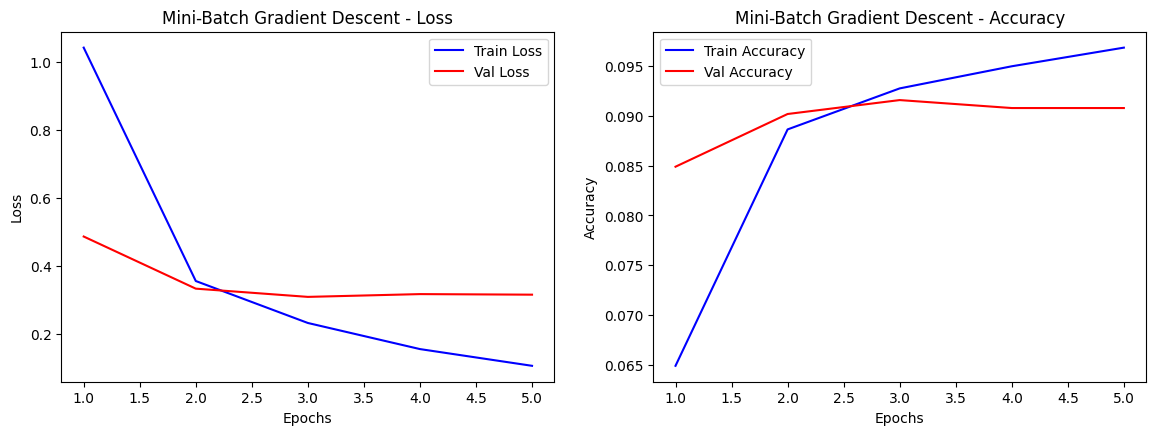

Epoch [1/5], Train Loss: 1.7570, Train Accuracy: 0.0077, Val Loss: 0.8544, Val Accuracy: 0.0146
Epoch [2/5], Train Loss: 0.6146, Train Accuracy: 0.0161, Val Loss: 0.5144, Val Accuracy: 0.0167
Epoch [3/5], Train Loss: 0.4082, Train Accuracy: 0.0175, Val Loss: 0.4190, Val Accuracy: 0.0173
Epoch [4/5], Train Loss: 0.3261, Train Accuracy: 0.0179, Val Loss: 0.3721, Val Accuracy: 0.0178
Epoch [5/5], Train Loss: 0.2746, Train Accuracy: 0.0183, Val Loss: 0.3459, Val Accuracy: 0.0179


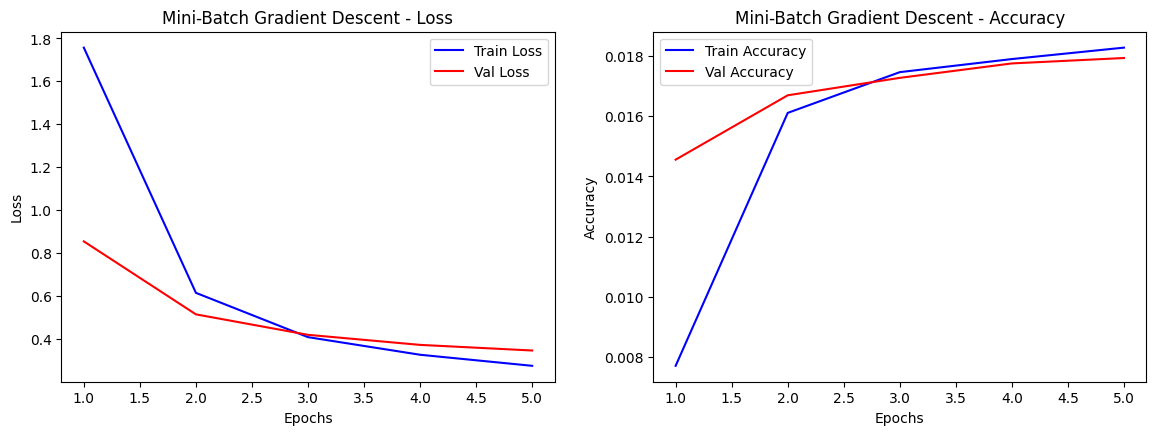


Training using learning rate:
10



Training using Stochastic Gradient Descent:
Epoch [1/5], Train Loss: 9.1058, Train Accuracy: 0.0955, Val Loss: 8.8819, Val Accuracy: 0.0022
Epoch [2/5], Train Loss: 8.9754, Train Accuracy: 0.1025, Val Loss: 8.8788, Val Accuracy: 0.0023
Epoch [3/5], Train Loss: 9.0054, Train Accuracy: 0.0995, Val Loss: 9.0379, Val Accuracy: 0.0020
Epoch [4/5], Train Loss: 9.0129, Train Accuracy: 0.0988, Val Loss: 9.0132, Val Accuracy: 0.0019
Epoch [5/5], Train Loss: 8.9804, Train Accuracy: 0.1020, Val Loss: 8.9817, Val Accuracy: 0.0019


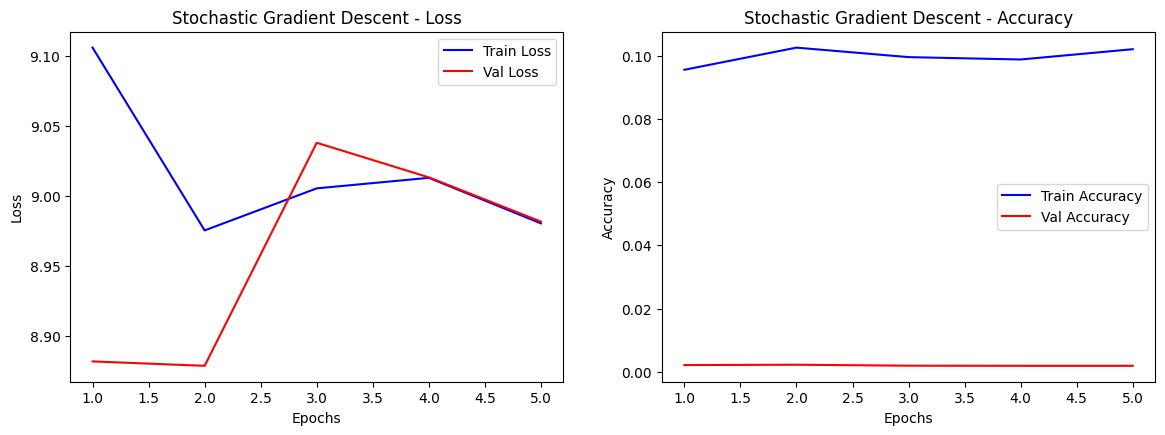


Training using Gradient Descent:
Epoch [1/5], Train Loss: 0.0006, Train Accuracy: 0.1037, Val Loss: 5.3183, Val Accuracy: 0.0023
Epoch [2/5], Train Loss: 0.0013, Train Accuracy: 0.1145, Val Loss: 3.9610, Val Accuracy: 0.0017
Epoch [3/5], Train Loss: 0.0010, Train Accuracy: 0.1037, Val Loss: 3.0661, Val Accuracy: 0.0020
Epoch [4/5], Train Loss: 0.0008, Train Accuracy: 0.1055, Val Loss: 2.8904, Val Accuracy: 0.0017
Epoch [5/5], Train Loss: 0.0007, Train Accuracy: 0.1097, Val Loss: 2.7274, Val Accuracy: 0.0017


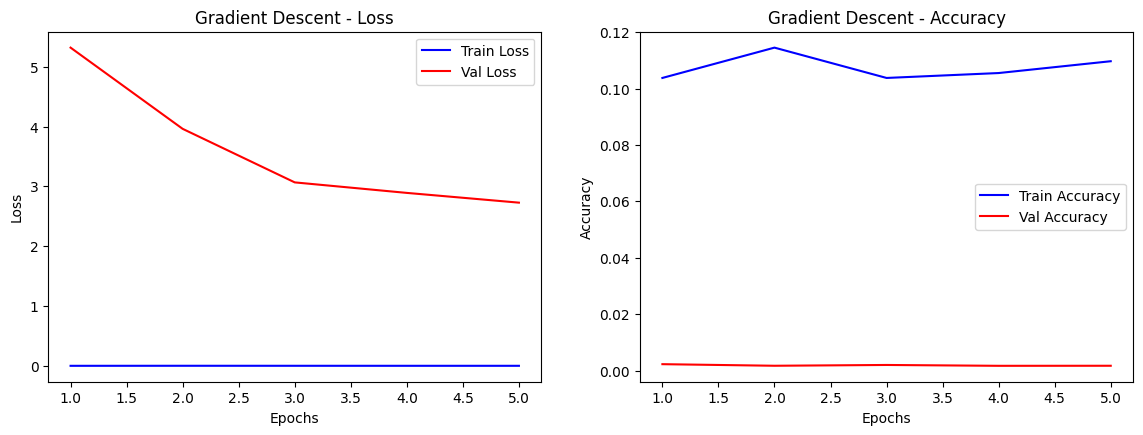


Training using Mini-Batch Gradient Descent:
Epoch [1/5], Train Loss: 3.0376, Train Accuracy: 0.0107, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [2/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [3/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [4/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096
Epoch [5/5], Train Loss: 2.9628, Train Accuracy: 0.0108, Val Loss: 3.3840, Val Accuracy: 0.0096


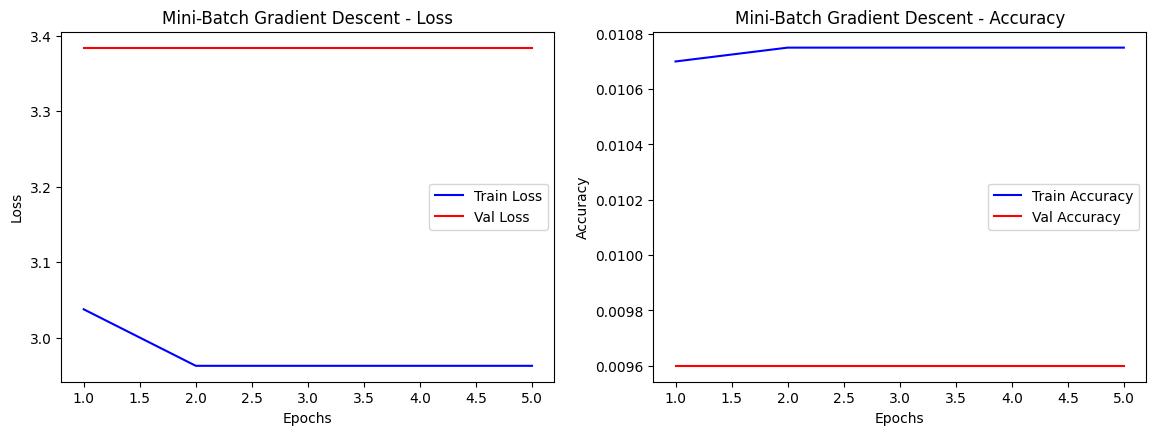

Epoch [1/5], Train Loss: 2.6079, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [2/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [3/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [4/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018
Epoch [5/5], Train Loss: 2.3996, Train Accuracy: 0.0021, Val Loss: 2.4120, Val Accuracy: 0.0018


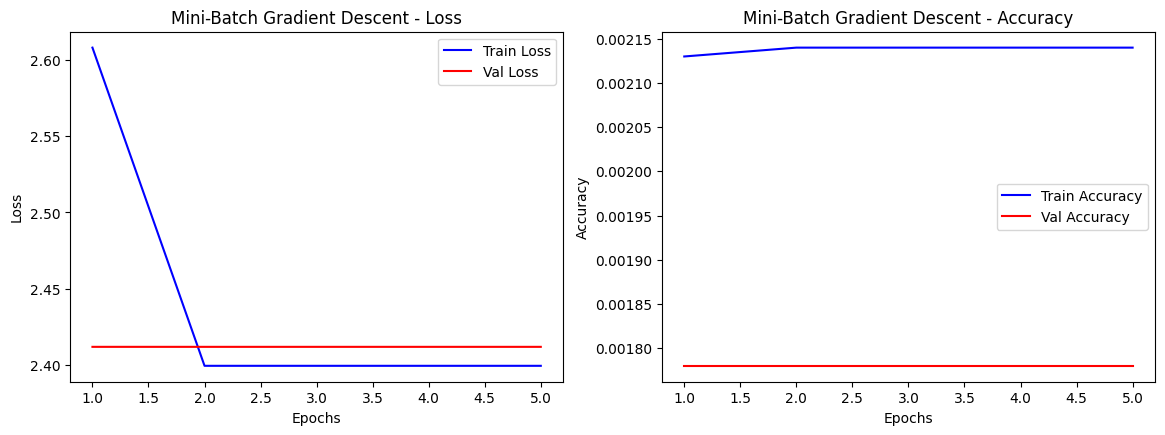

In [161]:
for hidden in hidden_size:
  print("\nTraining using size of the hidden layer:")
  print(hidden)
  print("\n")
  for learning in learning_rate:
    print("\nTraining using learning rate:")
    print(learning)
    print("\n")
    print("\nTraining using Stochastic Gradient Descent:")
    W1_sgd, b1_sgd, W2_sgd, b2_sgd, train_loss_history_sgd, train_accuracy_history_sgd, val_loss_history_sgd, val_accuracy_history_sgd = train('sgd', val_loader_sgd, train_loader_sgd, input_size, hidden, output_size, learning, 5)
    plot_results(train_loss_history_sgd, train_accuracy_history_sgd, val_loss_history_sgd, val_accuracy_history_sgd, 'Stochastic Gradient Descent')
    print("\nTraining using Gradient Descent:")
    W1_gd, b1_gd, W2_gd, b2_gd, train_loss_history_gd, train_accuracy_history_gd, val_loss_history_gd, val_accuracy_history_gd = train('gradient_descent', val_loader_sgd, train_loader_sgd, input_size, hidden, output_size, learning, 5)
    plot_results(train_loss_history_gd, train_accuracy_history_gd, val_loss_history_gd, val_accuracy_history_gd, 'Gradient Descent')
    print("\nTraining using Mini-Batch Gradient Descent:")
    for batch_size in epochs:
      train_loader_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      val_loader_sgd = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
      W1_batch, b1_batch, W2_batch, b2_batch, train_loss_history_batch, train_accuracy_history_batch, val_loss_history_batch, val_accuracy_history_batch = train('mini_batch', val_loader_sgd, train_loader_batch, input_size, hidden, output_size, learning, 5, batch_size)
      plot_results(train_loss_history_batch, train_accuracy_history_batch, val_loss_history_batch, val_accuracy_history_batch, 'Mini-Batch Gradient Descent')



Ao analisar os resultados de diferentes configurações de `hidden_size` (25, 50, 100) e `learning_rate` (0.5, 1, 10) usando Stochastic Gradient Descent (SGD), Gradient Descent (GD) e Mini-Batch Gradient Descent, observamos variações significativas na acurácia e na perda. Redes com uma camada oculta menor, como 25 unidades, geralmente não capturam bem a complexidade dos dados, resultando em maior perda e menor acurácia. Por outro lado, redes com 50 ou 100 unidades tendem a apresentar um equilíbrio melhor, com 50 unidades mostrando uma redução notável na perda e um aumento na acurácia, enquanto 100 unidades oferecem uma capacidade de modelagem aprimorada, mas com risco maior de overfitting. Em relação à taxa de aprendizado, uma taxa baixa de 0.5 resulta em convergência lenta, com perda diminuindo gradualmente e acurácia aumentando de forma estável, porém mais lentamente. Uma taxa moderada de 1 fornece um bom equilíbrio, promovendo rápida convergência e melhoria significativa na acurácia. No entanto, taxas altas de 10 causam grandes oscilações na perda e na acurácia, muitas vezes impedindo uma convergência adequada e resultando em desempenho instável. Quanto ao tamanho do batch no Mini-Batch Gradient Descent, utilizar um tamanho de batch menor (10) resultou em atualizações mais frequentes dos pesos, o que pode levar a uma perda mais volátil, mas a acurácia pode melhorar mais rapidamente nas primeiras épocas. Um tamanho de batch maior (50) proporcionou uma convergência mais suave e estável, com uma redução consistente na perda e aumento gradual na acurácia. Em resumo, a combinação de um tamanho de camada oculta de 50 ou 100 unidades com uma taxa de aprendizado moderada de 1 mostrou-se ideal para alcançar uma rápida diminuição na perda e um aumento na acurácia, enquanto configurações extremas de `hidden_size` e `learning_rate` tendem a resultar em desempenho subótimo.
